In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/695 project/financial_fraud_detection_dataset.csv'
df = pd.read_csv(file_path)


In [3]:


import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


In [4]:
print(df.shape)
print(df.head())

(5000000, 18)
  transaction_id                   timestamp sender_account receiver_account  \
0        T100000  2023-08-22T09:22:43.516168      ACC877572        ACC388389   
1        T100001  2023-08-04T01:58:02.606711      ACC895667        ACC944962   
2        T100002  2023-05-12T11:39:33.742963      ACC733052        ACC377370   
3        T100003  2023-10-10T06:04:43.195112      ACC996865        ACC344098   
4        T100004  2023-09-24T08:09:02.700162      ACC584714        ACC497887   

    amount transaction_type merchant_category location device_used  is_fraud  \
0   343.78       withdrawal         utilities    Tokyo      mobile     False   
1   419.65       withdrawal            online  Toronto         atm     False   
2  2773.86          deposit             other   London         pos     False   
3  1666.22          deposit            online   Sydney         pos     False   
4    24.43         transfer         utilities  Toronto      mobile     False   

  fraud_type  time_since

In [5]:
print(df.info)
#check the data information

<bound method DataFrame.info of         transaction_id                   timestamp sender_account  \
0              T100000  2023-08-22T09:22:43.516168      ACC877572   
1              T100001  2023-08-04T01:58:02.606711      ACC895667   
2              T100002  2023-05-12T11:39:33.742963      ACC733052   
3              T100003  2023-10-10T06:04:43.195112      ACC996865   
4              T100004  2023-09-24T08:09:02.700162      ACC584714   
...                ...                         ...            ...   
4999995       T5099995  2023-11-17T23:20:29.746144      ACC597319   
4999996       T5099996  2023-09-23T11:23:20.659686      ACC749625   
4999997       T5099997  2023-11-18T00:52:34.527092      ACC629492   
4999998       T5099998  2023-03-25T04:32:13.609837      ACC984720   
4999999       T5099999  2023-09-02T04:34:34.583803      ACC120255   

        receiver_account   amount transaction_type merchant_category  \
0              ACC388389   343.78       withdrawal         utilitie

In [6]:
df.isnull().sum()
#check if there is any data missing from the selecting sample


,0
transaction_id,0
timestamp,0
sender_account,0
receiver_account,0
amount,0
transaction_type,0
merchant_category,0
location,0
device_used,0
is_fraud,0


In [7]:
#need to deal with the null data use mean
df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(df['time_since_last_transaction'].mean())
df['fraud_type'] = df['fraud_type'].fillna('card_on_present')

In [8]:
df = df.drop("transaction_id", axis=1, errors='ignore')
#drop the id

In [9]:
print(df.columns)


Index(['timestamp', 'sender_account', 'receiver_account', 'amount',
       'transaction_type', 'merchant_category', 'location', 'device_used',
       'is_fraud', 'fraud_type', 'time_since_last_transaction',
       'spending_deviation_score', 'velocity_score', 'geo_anomaly_score',
       'payment_channel', 'ip_address', 'device_hash'],
      dtype='object')


In [10]:
df.describe()

,amount,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,3.589343e+02,1.525799e+00,-3.881160e-04,1.050132e+01,5.000293e-01
std,4.699333e+02,3.240098e+03,1.000807e+00,5.766842e+00,2.886349e-01
min,1.000000e-02,-8.777814e+03,-5.260000e+00,1.000000e+00,0.000000e+00
25%,2.657000e+01,-1.920275e+03,-6.800000e-01,5.000000e+00,2.500000e-01
50%,1.386700e+02,1.525799e+00,0.000000e+00,1.100000e+01,5.000000e-01
75%,5.038900e+02,1.923796e+03,6.700000e-01,1.600000e+01,7.500000e-01
max,3.520570e+03,8.757758e+03,5.020000e+00,2.000000e+01,1.000000e+00


In [11]:
df.dtypes
#check types for each cloumn

,0
timestamp,object
sender_account,object
receiver_account,object
amount,float64
transaction_type,object
merchant_category,object
location,object
device_used,object
is_fraud,bool
fraud_type,object


       transaction_count  fraud_rate
month                               
1.0               424718    0.035273
2.0               382551    0.036013
3.0               425454    0.035837
4.0               411054    0.035910
5.0               423451    0.035737
6.0               410890    0.035920
7.0               424492    0.036267
8.0               425546    0.035738
9.0               411277    0.036119
10.0              424906    0.036081
11.0              411100    0.035831
12.0              424558    0.036216


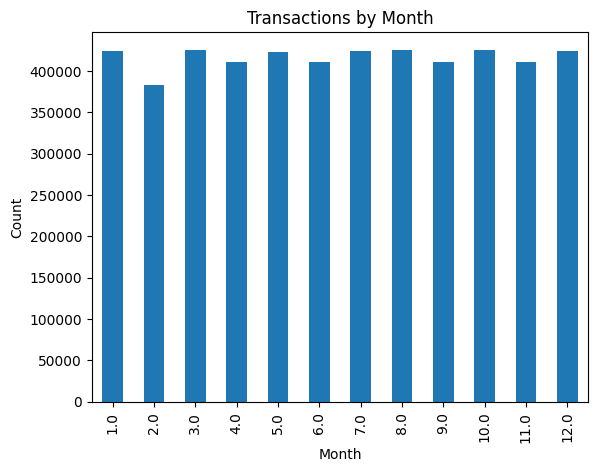

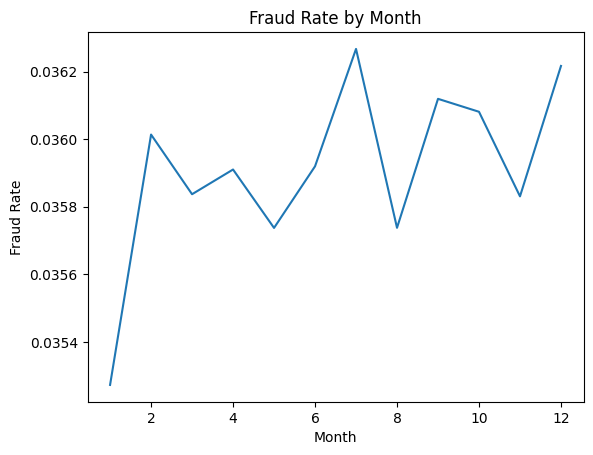

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'],errors='coerce')
df['month'] = df['timestamp'].dt.month
monthly_counts = df['month'].value_counts().sort_index()
fraud_rate = df.groupby('month')['is_fraud'].mean().sort_index()
summary_df = pd.DataFrame({
    'transaction_count': monthly_counts,
    'fraud_rate': fraud_rate
})
print(summary_df)
## Check the monthly reported activities

#plot transaction each month
plt.figure()
monthly_counts.plot(kind='bar')
plt.title('Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

#Plot fraud rate per month
plt.figure()
fraud_rate.plot()
plt.title('Fraud Rate by Month')
plt.xlabel('Month')
plt.ylabel('Fraud Rate')
plt.show()

       transaction_count  fraud_rate
month                               
1.0               424718    0.035273
2.0               382551    0.036013
3.0               425454    0.035837
4.0               411054    0.035910
5.0               423451    0.035737
6.0               410890    0.035920
7.0               424492    0.036267
8.0               425546    0.035738
9.0               411277    0.036119
10.0              424906    0.036081
11.0              411100    0.035831
12.0              424558    0.036216


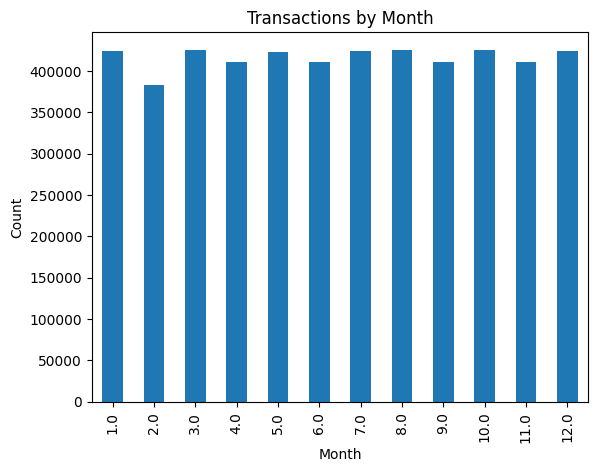

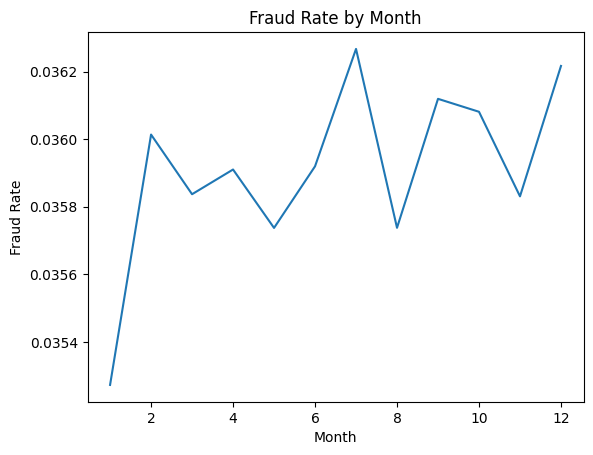

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['month'] = df['timestamp'].dt.month
monthly_counts = df['month'].value_counts().sort_index()
fraud_rate = df.groupby('month')['is_fraud'].mean().sort_index()
summary_df = pd.DataFrame({
    'transaction_count': monthly_counts,
    'fraud_rate': fraud_rate
})
print(summary_df)
## Check the monthly reported activities and fruad rate for each month

#plot transaction each month
plt.figure()
monthly_counts.plot(kind='bar')
plt.title('Transactions by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

#Plot fraud rate per month
plt.figure()
fraud_rate.plot()
plt.title('Fraud Rate by Month')
plt.xlabel('Month')
plt.ylabel('Fraud Rate')
plt.show()


is_fraud
False    96.40894
True      3.59106
Name: proportion, dtype: float64


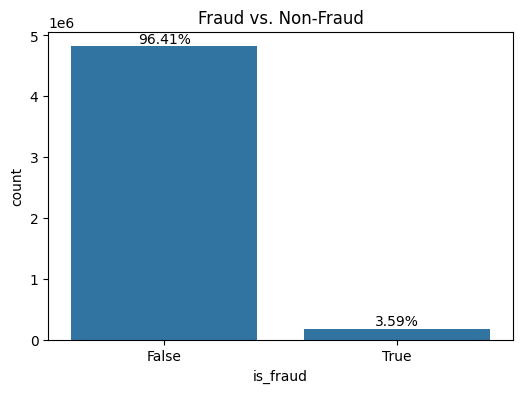

In [14]:
#check the difference between fruad and non fraud
# Percentage breakdown
fraud_counts = df['is_fraud'].value_counts(normalize=True) * 100
print(fraud_counts)

# Plot with percentage labels
plt.figure(figsize=(6,4))
ax = sns.countplot(x='is_fraud', data=df)
plt.title("Fraud vs. Non-Fraud")

# Add percentages on bars
for p in ax.patches:
    percentage = f'{(p.get_height() / len(df) * 100):.2f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height() + 50000),
                ha='center', fontsize=10)

plt.show()


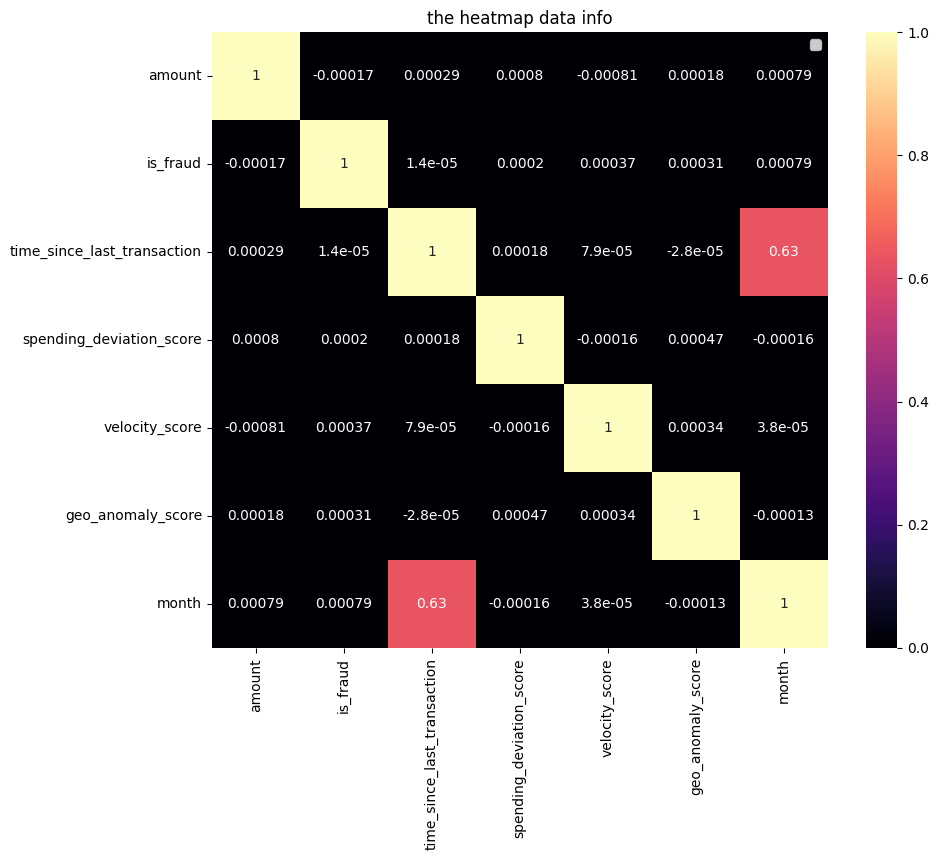

In [15]:
#plot a heatmap see correlation
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True),annot=True,square=True,cmap='magma')
plt.title('the heatmap data info')
plt.legend()
plt.show()


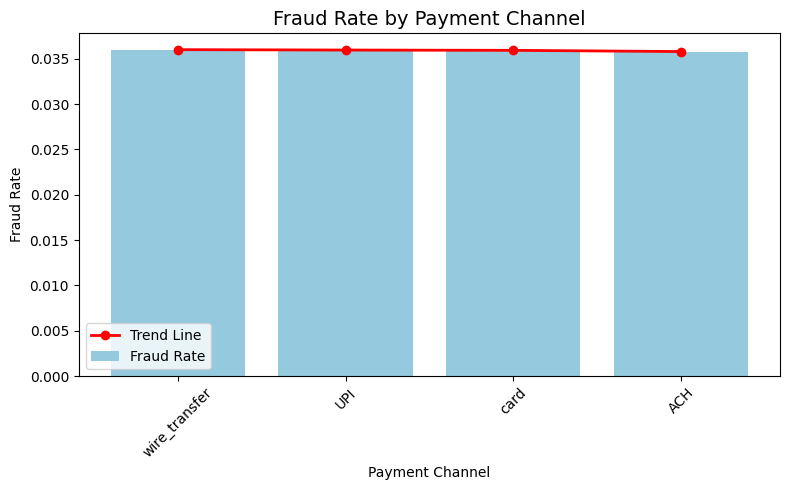

In [16]:
#fraud rate by pyamnet channel see if there is any channel outperform

# calcualte the fraud rate for each chanel
fraud_by_channel = df.groupby('payment_channel')['is_fraud'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))

sns.barplot(x=fraud_by_channel.index, y=fraud_by_channel.values, color='skyblue', label='Fraud Rate')


plt.plot(fraud_by_channel.index, fraud_by_channel.values, color='red', marker='o', linewidth=2, label='Trend Line')


plt.title("Fraud Rate by Payment Channel", fontsize=14)
plt.ylabel("Fraud Rate")
plt.xlabel("Payment Channel")
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()




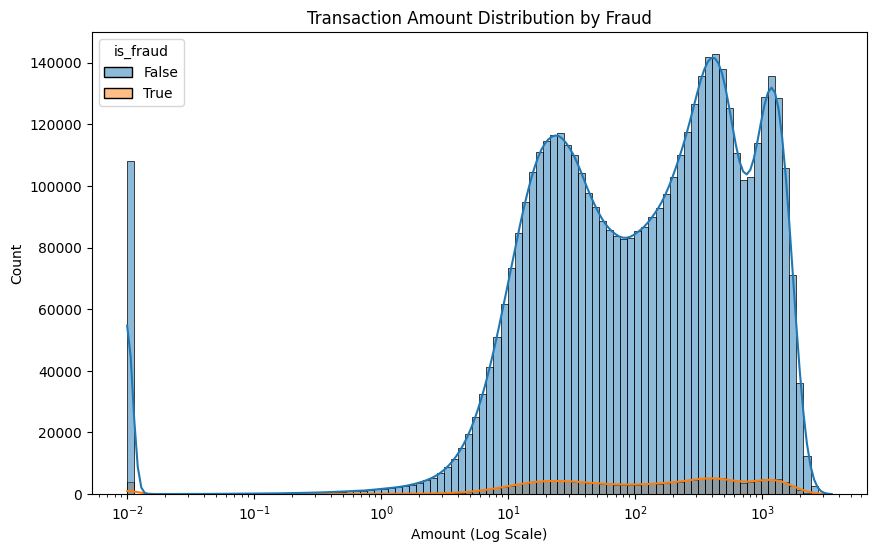

In [17]:
#Transaction Amount Distribution by Fraud use log scale
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='amount', hue='is_fraud', bins=100, log_scale=(True, False), kde=True)
plt.title("Transaction Amount Distribution by Fraud")
plt.xlabel("Amount (Log Scale)")
plt.show()


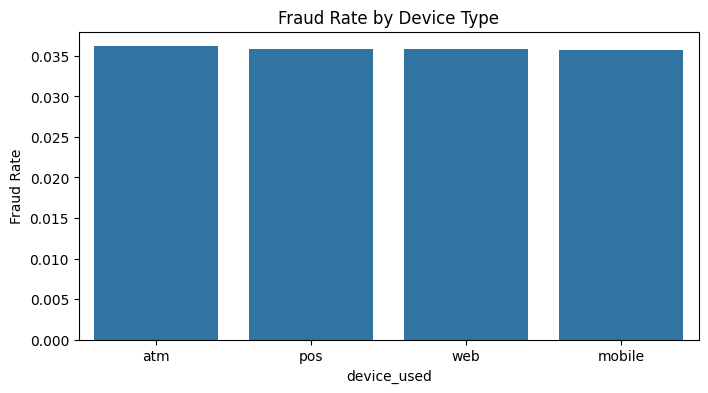

In [18]:
plt.figure(figsize=(8,4))
fraud_by_device = df.groupby('device_used')['is_fraud'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_device.index, y=fraud_by_device.values)
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by Device Type")
plt.show()